In [58]:

import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, CelebA, LSUN
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
from torch.utils.data.dataloader import DataLoader
import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image


Files already downloaded and verified


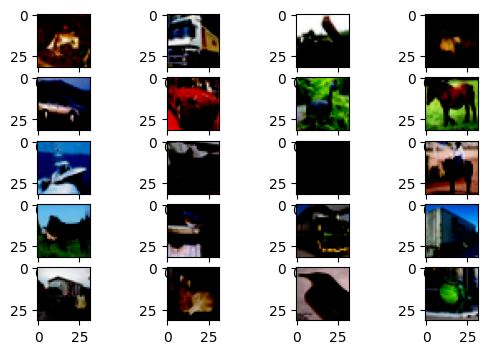

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

cifar10_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


"""
celeba_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
"""
"""
lsun_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
"""

cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar10_transform)
cifar10_train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=128, shuffle=True, num_workers=2)


"""
# CelebA
celeba_train = torchvision.datasets.CelebA(root='./data', split='train', download=True, transform=celeba_transform)
celeba_train_loader = torch.utils.data.DataLoader(celeba_train, batch_size=100, shuffle=True, num_workers=2)
"""
"""
# LSUN Bedroom
lsun_bedroom_train = torchvision.datasets.LSUN(root='./data', classes=['bedroom_train'], transform=lsun_transform)
lsun_bedroom_train_loader = torch.utils.data.DataLoader(lsun_bedroom_train, batch_size=100, shuffle=True, num_workers=2)

# LSUN Church
lsun_church_train = torchvision.datasets.LSUN(root='./data', classes=['church_outdoor_train'], transform=lsun_transform)
lsun_church_train_loader = torch.utils.data.DataLoader(lsun_church_train, batch_size=100, shuffle=True, num_workers=2)
"""


train_data = cifar10_train
train_data_loader = cifar10_train_loader

#Show some samples for the dataset
def showdatasample(dataset, sample_number, col):
    for i, img in enumerate(dataset):
        if i == sample_number:
            break
        plt.subplot(math.ceil(sample_number / col) + 1, col, i + 1)
        # Convert the image tensor to numpy array and transpose it to the format (height, width, channels)
        np_img = np.transpose(img[0].numpy(), (1, 2, 0))
        plt.imshow(np_img)

showdatasample(train_data, 20, 4)





The important part of this piece of code is the ddpm_forward. I want to explain the details of this code. 


The function takes the initial image x0, and a time step and returns the noisy image after t times of adding noises. 

Based on the paper, this is xt based with hyper parameter square root alph bar, square root one minus alpha bar and zt is the noise follows Gaussian distribution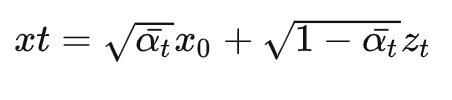

Therefore, the final output is (alpha_t * x0 + alpha_one_m_sqrt * noise)


In [60]:

#Set up the beta schedule, we use a simple linear schedule
def beta_schedule(steps):
  betas = torch.linspace(0.0001, 0.02, steps)
  return betas

#Intalize total time step 
step = 300
betas = beta_schedule(step)

#print("beta is: ", betas)

#Alpha = 1 = beta
alphas = 1. - betas

#cumulative product of alpha
alphas_bar = torch.cumprod(alphas, dim=0)

#hyper parameters need for forward and reverse process
alphas_bar_prev = torch.cat([torch.tensor([1]).float(), alphas_bar[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_bar)
one_m_alphas_sqrt = torch.sqrt(1 - alphas_bar)
one_m_alphas_log = torch.log(1- alphas_bar)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

alphas_bar_sqrt = alphas_bar_sqrt.to(device)
one_m_alphas_sqrt = one_m_alphas_sqrt.to(device)

posterior_variance = betas * (1. - alphas_bar_prev) / (1. - alphas_bar)

#This function returns the gathering elements from vals using the indices in t, 
#and reshaping it to the desired shape. we use it to get the hyperparameter at 
#time step t
def get_index_from_list(vals, t, x_shape):


    out = vals.gather(-1, t)
    
    # Calculate the output shape
    out_shape = [t.shape[0]] + [1] * (len(x_shape) - 1)
    out = out.reshape(*out_shape).to(t.device)
    
    return out

#This function returns the image after added noise at time step t
def ddpm_forward(x0, t):
    device = x0.device
    
    noise = torch.randn(x0.size()).to(device)
    #alpha_t = alphas_bar_sqrt.index_select(0, t).to(device)  
    alpha_t = get_index_from_list(alphas_bar_sqrt, t, x0.shape).to(device)
    
    #alpha_one_m_sqrt = one_m_alphas_sqrt.index_select(0, t).to(device) 
    alpha_one_m_sqrt = get_index_from_list(one_m_alphas_sqrt, t, x0.shape).to(device)
    return (alpha_t * x0 + alpha_one_m_sqrt * noise), noise





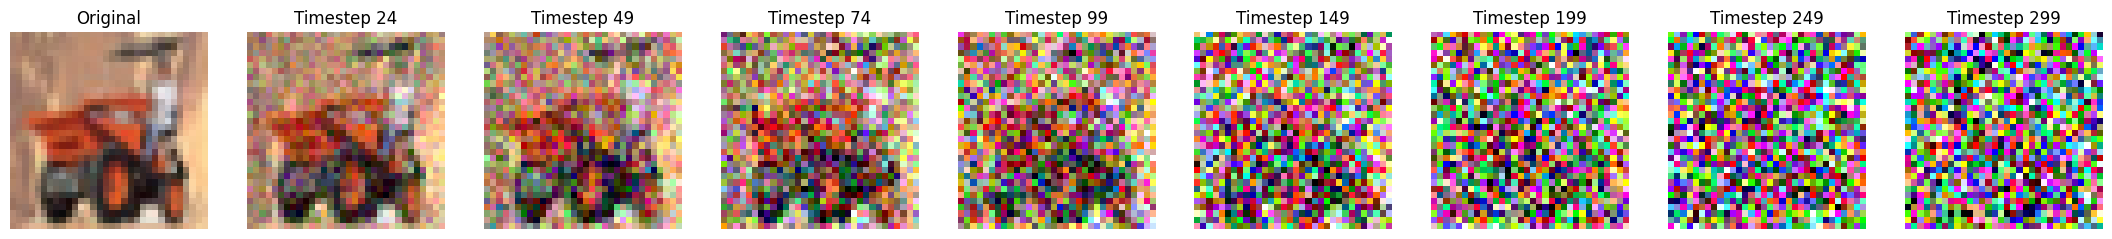

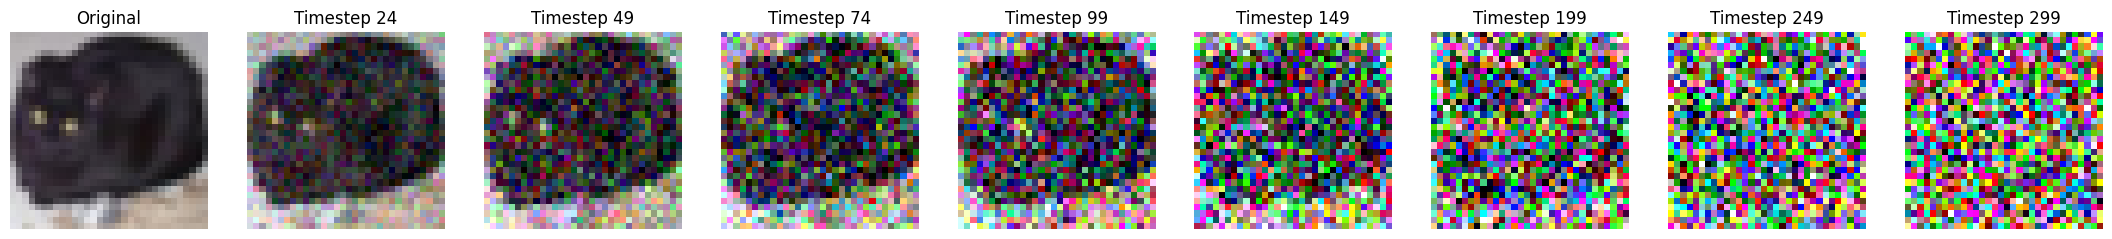

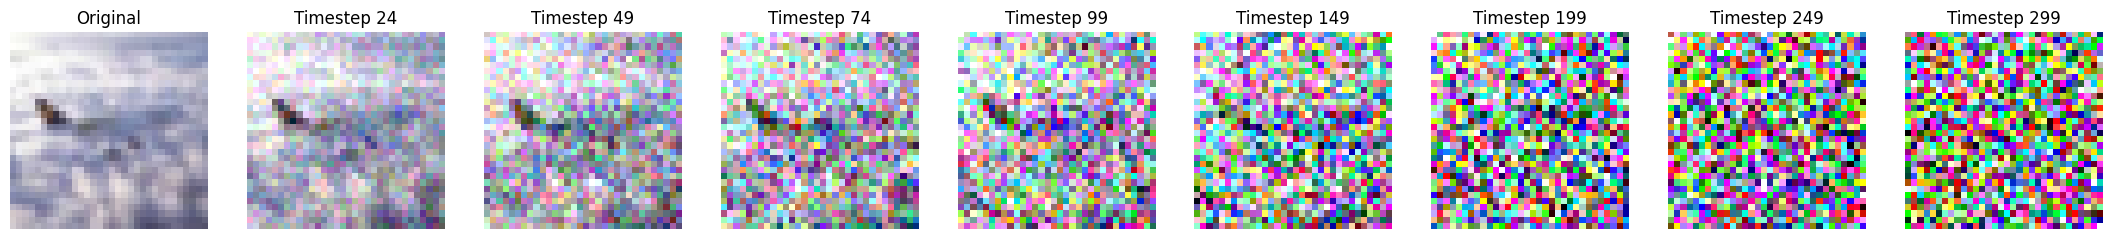

In [61]:

#A list for the image to be ploted at the following timestep
show_list = [24, 49, 74, 99, 149, 199, 249, 299]

#This function shows the images in a row, is used in the ddpm forward test function
def show_images_in_row(images, titles=None):
    num_images = len(images)
    fig, axs = plt.subplots(1, num_images, figsize=(3 * num_images, 3))
    for i, img_tensor in enumerate(images):
        img_np = img_tensor.cpu().numpy().transpose((1, 2, 0)) * 0.5 + 0.5  # Un-normalize
        axs[i].imshow(img_np)
        axs[i].axis('off')
        if titles is not None:
            axs[i].set_title(titles[i])
    plt.show()

#Test the forward method on a single image from the dataset
def test_ddpm_forward_on_single_image(data_loader, num_timesteps=5):
    img, _ = next(iter(data_loader))
    img = img.to(device)

    noisy_images = []
    titles = ['Original']
    noisy_images.append(img[0])

    for t in range(1, num_timesteps):
        #Get the noisy image at a certain timestep t
        noisy_img, _ = ddpm_forward(img, torch.tensor([t]).to(device))
        if (t  in show_list):
          noisy_images.append(noisy_img[0])
          titles.append(f'Timestep {t}')

    show_images_in_row(noisy_images, titles=titles)

test_ddpm_forward_on_single_image(train_data_loader, num_timesteps=300)
test_ddpm_forward_on_single_image(train_data_loader, num_timesteps=300)
test_ddpm_forward_on_single_image(train_data_loader, num_timesteps=300)

In [62]:
#This is a simple Unet structure we implementated, it includes a Transformer sinusoidal position embedding
#That acts as a important part of time embedding in each Unet block, it is from the paper [1]. 
#We do not have more gpu resource to implement a more complex one but the overall structure is 
#very simiar to the DDPM paper [2]


#[1] Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Łukasz
#Kaiser, and Illia Polosukhin. Attention is all you need. In Advances in Neural Information Processing
#Systems, pages 5998–6008, 2017.

#[2] https://arxiv.org/pdf/2006.11239.pdf

import torch.nn.functional as F

IMG_SIZE = 32
BATCH_SIZE = 128


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim, device):
        super().__init__()
        self.dim = dim
        self.device = device

    def forward(self, time):
        device = self.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class TimeEmbeddingUnit(nn.Module):
    def __init__(self, time_emb_dim, device):
        super(TimeEmbeddingUnit, self).__init__()
        self.time_emb_dim = time_emb_dim
        self.device = device
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(self.time_emb_dim, self.device),
            nn.Linear(self.time_emb_dim, self.time_emb_dim),
            nn.ReLU()
        )

    def forward(self, time):
        return self.time_mlp(time)

class UNetConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

class UNetUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetUpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = UNetConvBlock(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat((x, skip), dim=1)
        x = self.conv_block(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, device):
        super(UNet, self).__init__()
        self.time_embedding_unit = TimeEmbeddingUnit(time_emb_dim, device)

        self.enc1 = UNetConvBlock(in_channels, 64)
        self.enc2 = UNetConvBlock(64, 128)
        self.enc3 = UNetConvBlock(128, 256)
        self.enc4 = UNetConvBlock(256, 512)

        self.center = UNetConvBlock(512, 1024)

        self.dec4 = UNetUpBlock(1024, 512)
        self.dec3 = UNetUpBlock(512, 256)
        self.dec2 = UNetUpBlock(256, 128)
        self.dec1 = UNetUpBlock(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x, t):
        time_embedding = self.time_embedding_unit(t)
        time_embedding = time_embedding.view(time_embedding.size(0), time_embedding.size(1), 1, 1)

        x1 = self.enc1(x)
        x2 = F.max_pool2d(x1, 2)
        x2 = self.enc2(x2)
        x3 = F.max_pool2d(x2, 2)
        x3 = self.enc3(x3)
        x4 = F.max_pool2d(x3, 2)
        x4 = self.enc4(x4)

        x = F.max_pool2d(x4, 2)
        x = self.center(x)

        x = self.dec4(x, x4)
        x = self.dec3(x, x3)
        x = self.dec2(x, x2)
        x = self.dec1(x, x1)

        x = x + time_embedding
        x = self.out_conv(x)
        return x



I also want to talk the loss a little, because the loss is also identified in the paper as following:

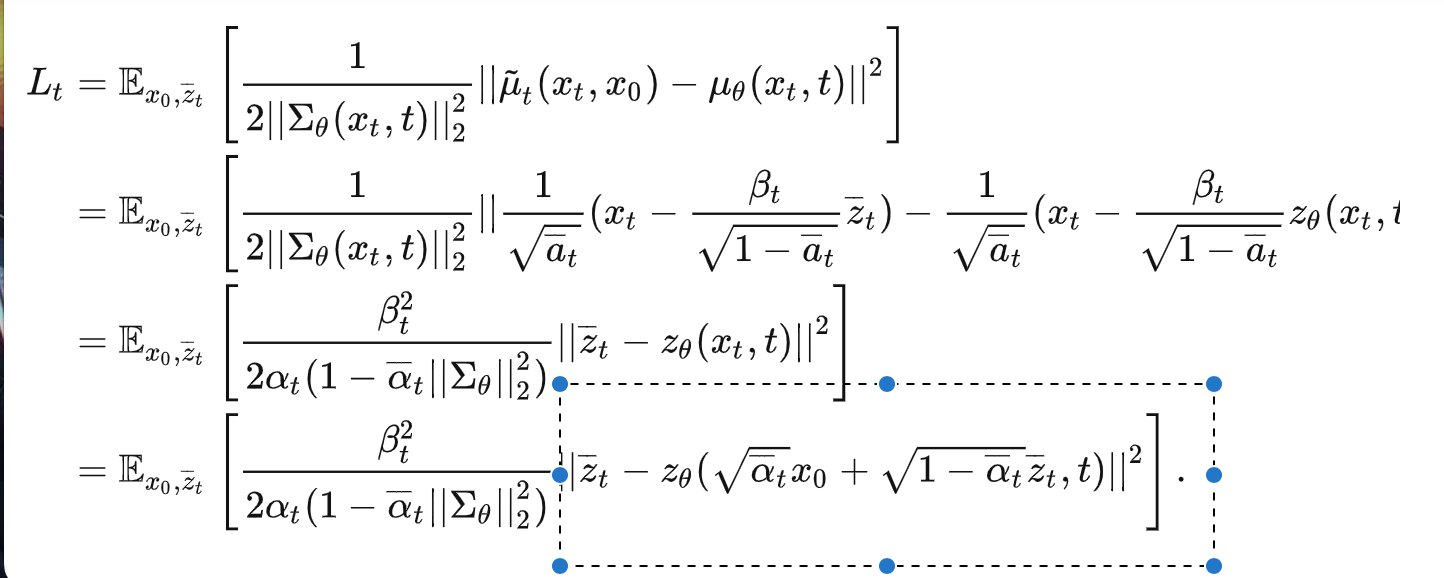

What we want is to minimize the circulted part, which is the MSE different between the predicted noise and the actual noise


In [63]:


def model_loss(model, x0, t):

  
  x_t, noise = ddpm_forward(x0, t)

  # Move input tensor and model to the same device
  device = x_t.device
  model = model.to(device)
  x_t = x_t.to(device)

  output = model(x_t, t)

  loss = torch.nn.functional.mse_loss(noise, output)

  return loss



In [65]:

#Sets up in and out channel
in_channels = 3
out_channels = 3
time_emb_dim = 64
model = UNet(in_channels, out_channels, time_emb_dim, device).to(device)

# Set the loss criterion and optimizer

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000


for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_data_loader, 0):
        #loads data
        inputs, _ = data
        inputs = inputs.to(device)
        
        #Set a random time step t between 0 and 300 for training
        t = torch.randint(0, step, (inputs.shape[0],), device=device).long()


        optimizer.zero_grad()
        #Get the loss with the model
        loss = model_loss(model, inputs, t)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print the average loss for this epoch
    print(f'Epoch {epoch + 1}, Loss: {running_loss / (i + 1)}')

print('Finished training')


In [ ]:
#Save the model here
model_path = "DDPM.pth"
torch.save(model.state_dict(), model_path)

In [ ]:
#download the model
from google.colab import files
files.download('DDPM.pth') 


In [66]:



#I have the model file if you dont want to spend time training it you can load it right here
in_channels = 3
out_channels = 3
time_emb_dim = 64

model = UNet(in_channels, out_channels, time_emb_dim, device).to(device)

model_weight = torch.load('DDPM.pth', map_location=device)

model.load_state_dict(model_weight)
model = model.to(device)




The sample part is also I want to explain, because the paper did not denoise the image 300 times to get the final generated result. The generated result can also be computed with some formulas. The final equation is here: 
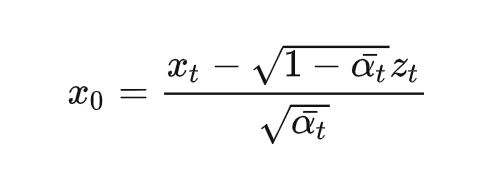

Where leads to the equation: 
model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / one_m_alphas_sqrt_t
    )

However, this is just the equation for x0, for any other states between xt and x0, the final output has to be adding this part of the followin equation with some noise value at that timestep

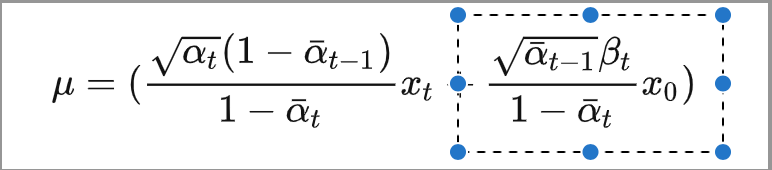

In [67]:
model.eval()

#Show image from a tensor image
def show_image(tensor_image):
    np_img = tensor_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    np_img = (np_img * 0.5) + 0.5  # Unnormalize
    plt.imshow(np_img)
    plt.show()

#The denoise steps
display_steps = [299, 250, 200, 150, 100, 50, 0]


def sample_timestep(x, t):
    t = t.to(device)
    #get the corresponding beta value at timestep t
    betas_t = get_index_from_list(betas, t, x.shape)
    #get the corresponding alpha sqrt value at time step t
    one_m_alphas_sqrt_t = get_index_from_list(
        one_m_alphas_sqrt, t, x.shape
    )
    #get the square root one over alpha at timestep t
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / one_m_alphas_sqrt_t
    )

    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

#if you wish to display the image, please run this function
def denoise_display():
  with torch.no_grad():
    #generate a complete noisy image 
      image = torch.randn(1, in_channels, IMG_SIZE, IMG_SIZE).to(device)

      for i in range(300 - 1, -1, -1):
          t = torch.full((1,), i, device=device, dtype=torch.long)
          image = sample_timestep(image, t)
          if i in display_steps:
            print("Time step: ", i)
            show_image(image)

#If you wish to save the image, pls run denoise_save
def denoise_save():
  with torch.no_grad():
      image = torch.randn(1, in_channels, IMG_SIZE, IMG_SIZE).to(device)

      for i in range(300 - 1, -1, -1):
          t = torch.full((1,), i, device=device, dtype=torch.long)
          image = sample_timestep(image, t)
          if i in display_steps:
            image_name = f'image_timestep_{i}.png'
            save_image(image, image_name)

test sample 1: 
Time step:  299


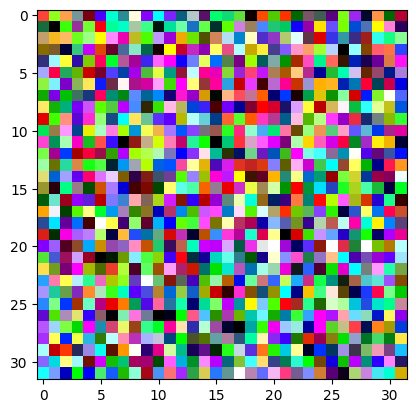

Time step:  250


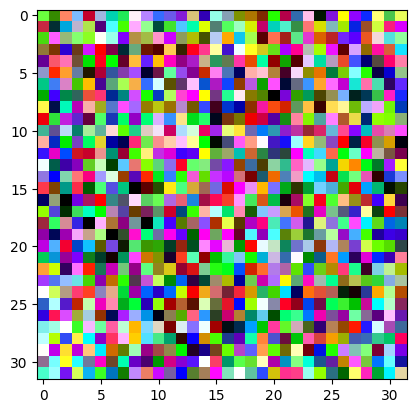

Time step:  200


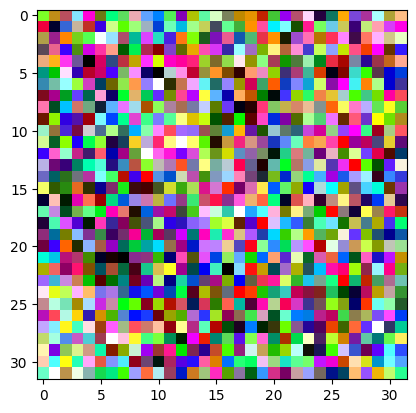

Time step:  150


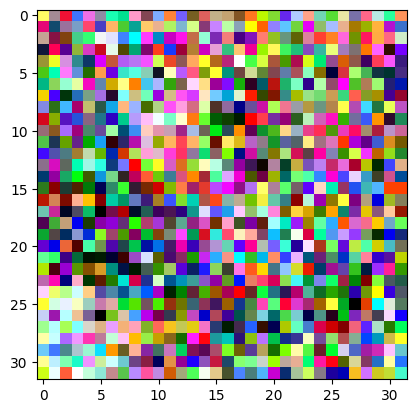

Time step:  100


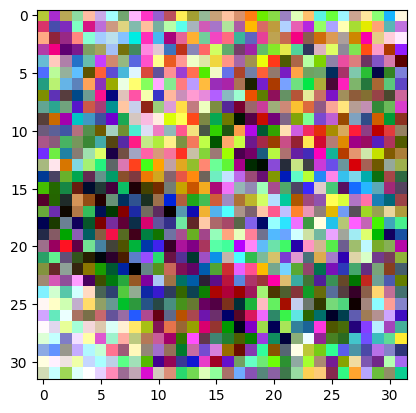

Time step:  50


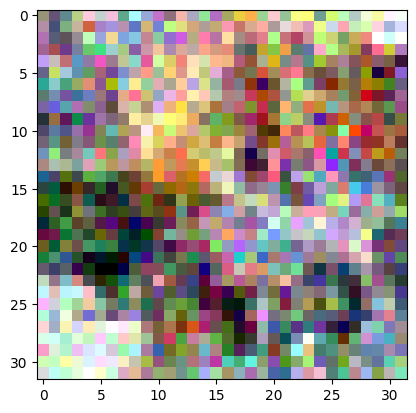

Time step:  0


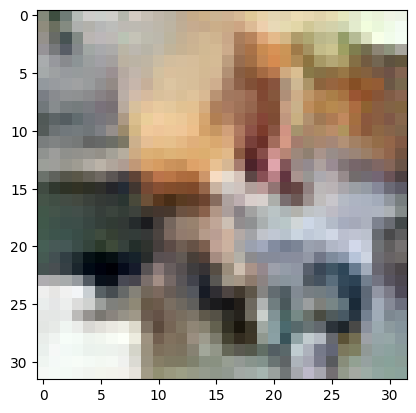

test sample 2: 


Time step:  299


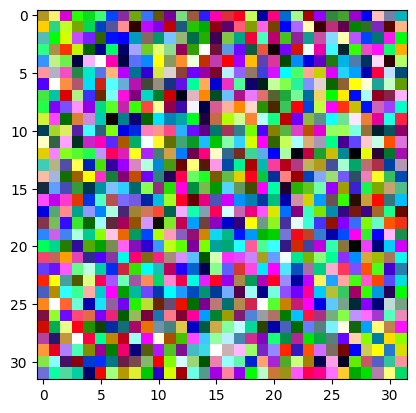

Time step:  250


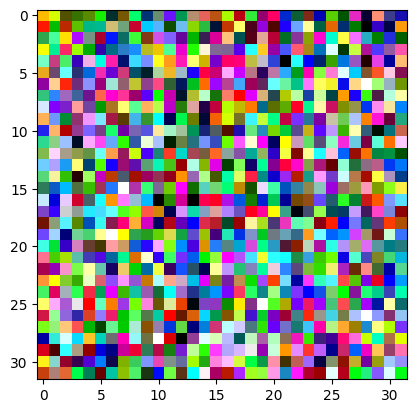

Time step:  200


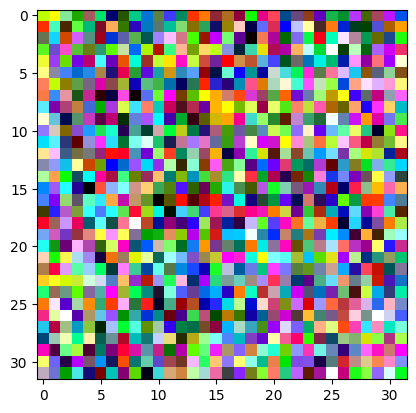

Time step:  150


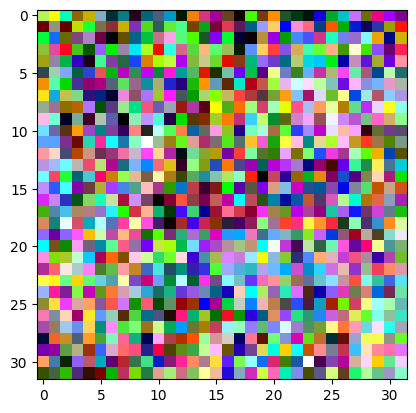

Time step:  100


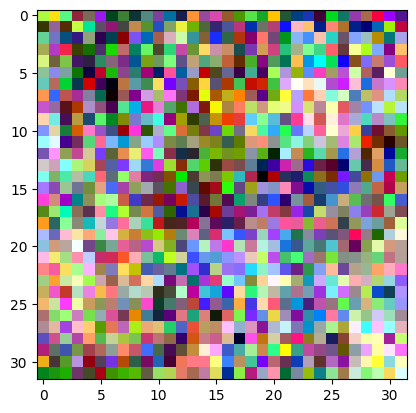

Time step:  50


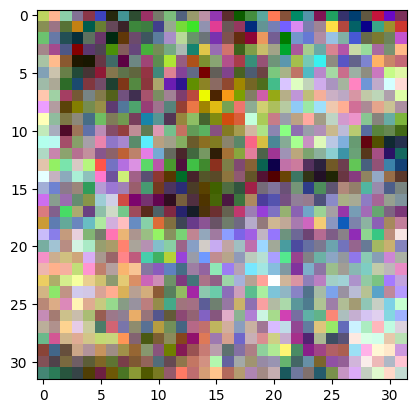

Time step:  0


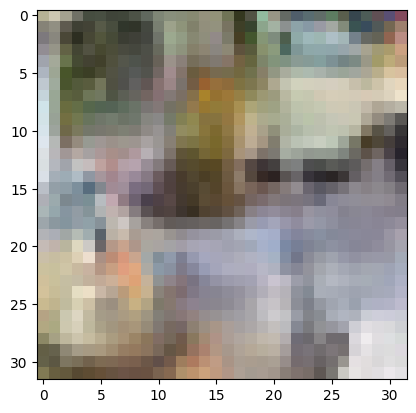

test sample 3: 


Time step:  299


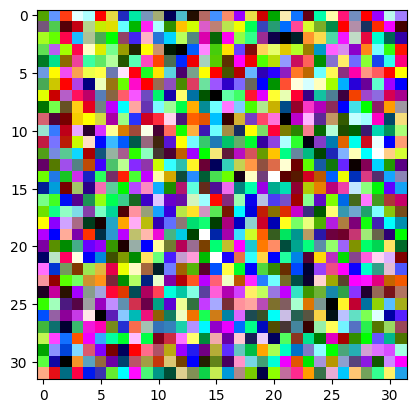

Time step:  250


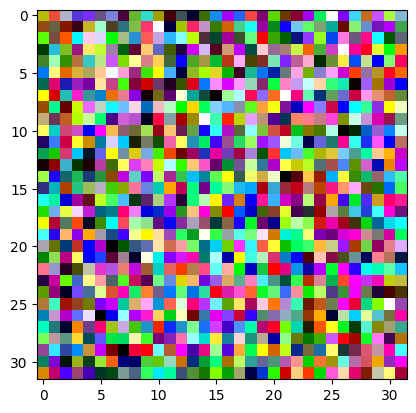

Time step:  200


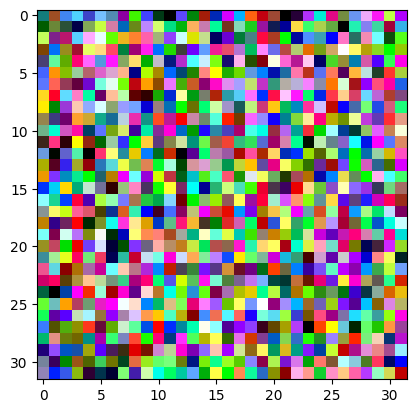

Time step:  150


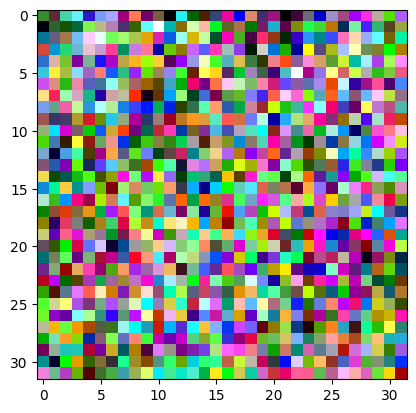

Time step:  100


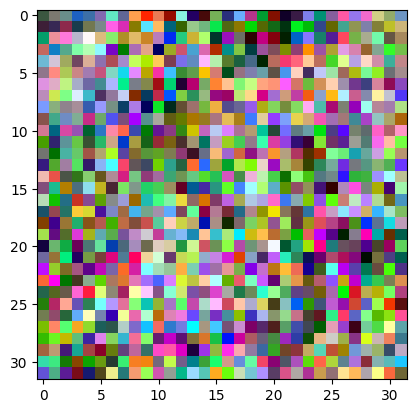

Time step:  50


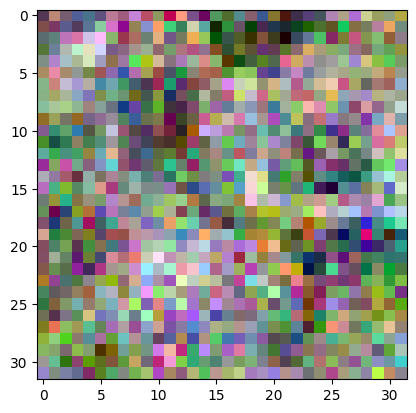

Time step:  0


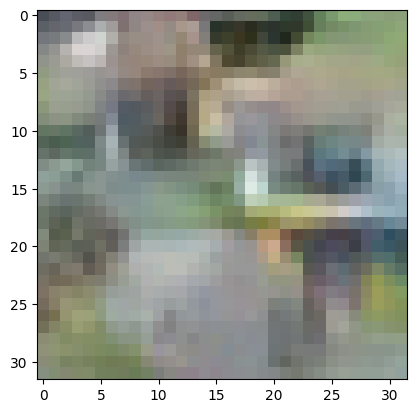

In [68]:
#display denoise process
print("test sample 1: ")
denoise_display()
print("test sample 2: ")
denoise_display()
print("test sample 3: ")
denoise_display()


In [47]:
#Save the denoise process image, you can do it a couple times to get different results
denoise_save()

In [69]:
#Here I print out the FID score at the different time step for this model to compare with the
#paper

!pip install pytorch-fid
import os
from torchvision.utils import save_image
from pytorch_fid.fid_score import calculate_fid_given_paths


#Modify the denoise_save funtion a little bit for saving a chunk of generated image at each time step
def denoise_save(num_images=1000):
    for i in range(300 - 1, -1, -1):
        if i in display_steps:
            # Create a directory for each timestep
            dir_name = f'images_timestep_{i}'
            os.makedirs(dir_name, exist_ok=True)

            for img_idx in range(num_images):
                image = torch.randn(1, in_channels, IMG_SIZE, IMG_SIZE).to(device)
                t = torch.full((1,), i, device=device, dtype=torch.long)
                image = sample_timestep(image, t)
                image_name = f'{dir_name}/image_{img_idx}.png'
                save_image(image, image_name)


real_images_folder = 'real_images'
os.makedirs(real_images_folder, exist_ok=True)

num_real_images = 1000


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
for i in display_steps:
    generated_images_path = f'images_timestep_{i}'
    fid = calculate_fid_given_paths([real_images_folder, generated_images_path], dims=2048, batch_size=128, device=device)
    print(f"FID score at timestep {i}: {fid}")

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 294MB/s]
100%|██████████| 8/8 [01:44<00:00, 13.00s/it]


FID score at timestep 299: 348.0847032157328


100%|██████████| 8/8 [01:40<00:00, 12.61s/it]


FID score at timestep 250: 347.71607089431234


100%|██████████| 8/8 [01:40<00:00, 12.52s/it]


FID score at timestep 200: 347.4763672685605


100%|██████████| 8/8 [01:41<00:00, 12.63s/it]


FID score at timestep 150: 347.58315149930405


100%|██████████| 8/8 [01:40<00:00, 12.56s/it]


FID score at timestep 100: 346.44303252659165


100%|██████████| 8/8 [01:40<00:00, 12.51s/it]


FID score at timestep 50: 346.89541243697965


100%|██████████| 8/8 [01:41<00:00, 12.67s/it]


FID score at timestep 1: 347.47162265506347
